<a href="https://colab.research.google.com/github/anabarrerar/AnaBarrera_Portfolio/blob/main/ICR%20-%20Identifying%20Age-Related%20Conditions%20/Forecast_Ensemble_Method_ICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [96]:
!unzip icr-identify-age-related-conditions.zip

In [95]:
#!pip install lightgbm==3.2.0
#!pip install xgboost
#!pip install catboost --upgrade
#!pip install tabpfn
#!pip install imbalanced-learn

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
import gc

from tqdm.auto import tqdm
import math
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tabpfn import TabPFNClassifier
from sklearn.model_selection import KFold as KF, GridSearchCV

from glob import glob
from pathlib import Path
import joblib
import pickle
import os
import random
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.impute import SimpleImputer
from datetime import datetime

import time
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Data




In [97]:
#Read the data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
greeks=pd.read_csv("greeks.csv")
submission_df=pd.read_csv("sample_submission.csv")

In [3]:
predictor_columns = [n for n in train.columns if n != 'Class' and n != 'Id']
categorical_features = ['EJ']

train.Class.value_counts()/train.shape[0]

0    0.824959
1    0.175041
Name: Class, dtype: float64

The objective variable is not balanced, which means that there are many more representative records of class 0 than of class 1, with 0.82% versus 18% respectively.

In [4]:
#Encoding EJ
first_category = train.EJ.unique()[0]
train.EJ = train.EJ.eq(first_category).astype('int')
test.EJ = test.EJ.eq(first_category).astype('int')

# Models

**METRIC:**
The balanced logarithmic loss is particularly useful when dealing with imbalanced datasets, where one class is much more prevalent than the other. It penalizes misclassifications of the minority class more heavily, thereby providing a more balanced evaluation metric for the classifier's performance. This can be important in cases where misclassifying the minority class is more critical or costly than misclassifying the majority class.

The function we will use returns the average log loss, which is the balanced log loss divided by the total number of observations (N_0 + N_1).




In [29]:
def balanced_log_loss(y_true, y_pred): # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

We define the functions corresponding to the algorithms

In [30]:
#LIGHTGBM
def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid, categorical_feature=categorical_features)
    model = lgb.LGBMClassifier()
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)
    proba_pred = model.predict_proba(x_valid) #Predicting in the validation fold
    return model, proba_pred

#XGBOOST
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    xgb_train = xgb.DMatrix(data=x_train, label=y_train)
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid)
    model = xgb.XGBClassifier()
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)
    proba_pred = model.predict_proba(x_valid)#[:, 1] # Las probabilidades de la clase positiva (clase 1) están en la segunda columna
    return model, proba_pred

#CATBOOST
def catboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    cat_train = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    cat_valid = Pool(data=x_valid, label=y_valid, cat_features=categorical_features)
    model = CatBoostClassifier()
    model.fit(cat_train,eval_set=[cat_valid], verbose=False)
    proba_pred = model.predict_proba(x_valid)#[:, 1]
    return model, proba_pred

We will define a function which performs cross-validation for ensemble boosting methods using different classifiers like LightGBM, XGBoost, CatBoost, and TabPFN (The TabPFN is a neural network that learned to do tabular data prediction. This is the original CUDA-supporting pytorch impelementation).

The probability analysis is performed to ensure that the final binary predictions are appropriately balanced based on the threshold values, taking into consideration the different classifiers' predictions and their respective probabilities. This helps in handling class imbalance and achieving better classification performance.

In [34]:
seed=42

def boosting_CV_methods(method: str, x, y):
    outer_results = list() #validation losses
    best_loss = np.inf
    splits = 5 #folds
    best_model = None # Store the best model
    best_y_p = None  # Store best predictions

    for split, (train_idx, val_idx) in enumerate(KF(n_splits=splits, shuffle=True, random_state=42).split(x)):
        print('-'*50)
        print(f'{method} training fold {split + 1}')
        x_train, x_valid = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[val_idx]

        if method == 'lightgbm':
            model, pred_proba = lightgbm_training(x_train, y_train, x_valid, y_valid, predictor_columns, categorical_features)
        if method == 'xgboost':
            model, pred_proba = xgboost_training(x_train, y_train, x_valid, y_valid, predictor_columns, categorical_features)
        if method == 'catboost':
            model, pred_proba = catboost_training(x_train, y_train, x_valid, y_valid, predictor_columns, categorical_features)
        if method == 'TabPFN':
            model = TabPFNClassifier(N_ensemble_configurations=64,)
            model.fit(x_train, y_train,overwrite_warning=True)
            pred_proba = model.predict_proba(x_valid)

        # Convert probabilities to binary predictions using a threshold
        probabilities = np.concatenate((pred_proba[:, :1], np.sum(pred_proba[:, 1:], 1, keepdims=True)), axis=1) #pred_proba class 1.
        p0 = probabilities[:, :1] #probabilities of class 0
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((pred_proba.shape[0],))
        for i in range(pred_proba.shape[0]): # Converting to binary prediction
            if p0[i] >= 0.5:
                y_p[i] = False #Class 0
            else:
                y_p[i] = True #Class 1
        y_p = y_p.astype(int)

        loss = balanced_log_loss(y_valid, y_p)
        if not np.isnan(loss):
            if loss < best_loss:
                best_model = model
                best_loss = loss
                best_y_p = y_p  # Store the predictions for the best model
                print('best_model_saved')
            outer_results.append(loss)
            print('>val_loss=%.5f' % loss)
        else:
            print('Invalid loss, skipping fold.')

    print('LOSS: %.5f' % (np.mean(outer_results)),'\n\n\n')
    return best_model, best_y_p

## Model implementation

In [86]:
x=train.drop(['Class', 'Id'],axis=1) #train data
y=train.Class #target

y_preds = {} # Initialize arrays to store predictions for each method

for method in ['lightgbm', 'xgboost', 'catboost', 'TabPFN']:
    model, _ = boosting_CV_methods(method, x, y)  # Note the "_" which ignores the second return value
    y_pred = model.predict_proba(x)[:, 1]  # Use the entire dataset for predictions
    y_preds[method] = y_pred

--------------------------------------------------
lightgbm training fold 1
best_model_saved
>val_loss=2.92915
--------------------------------------------------
lightgbm training fold 2
best_model_saved
>val_loss=1.55443
--------------------------------------------------
lightgbm training fold 3
>val_loss=2.10032
--------------------------------------------------
lightgbm training fold 4
>val_loss=3.89015
--------------------------------------------------
lightgbm training fold 5
>val_loss=3.08199
LOSS: 2.71121 



--------------------------------------------------
xgboost training fold 1
best_model_saved
>val_loss=1.81499
--------------------------------------------------
xgboost training fold 2
best_model_saved
>val_loss=1.02432
--------------------------------------------------
xgboost training fold 3
>val_loss=2.93131
--------------------------------------------------
xgboost training fold 4
>val_loss=4.71201
--------------------------------------------------
xgboost training fold

In [88]:
def show_confusion_roc(y_true, y_pred, title='evaluation results'):
    f, ax = plt.subplots(1, 2, figsize=(11.3, 3))
    cm = confusion_matrix(y_true, (y_pred >= 0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='GnBu_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1])
    plt.suptitle(f'{title}', fontsize=12, fontweight='bold', y=0.95, x=0.72)
    plt.tight_layout()
    plt.grid()

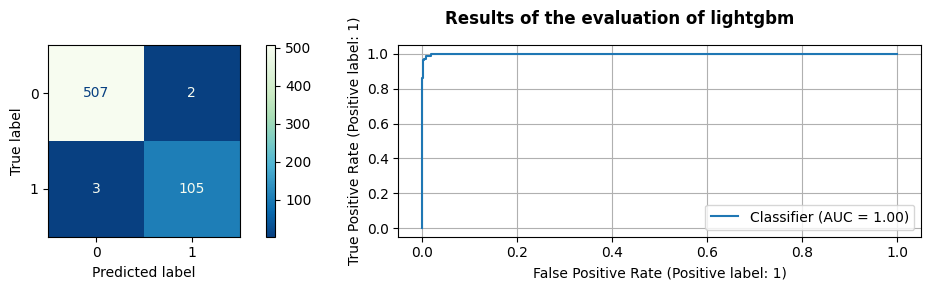

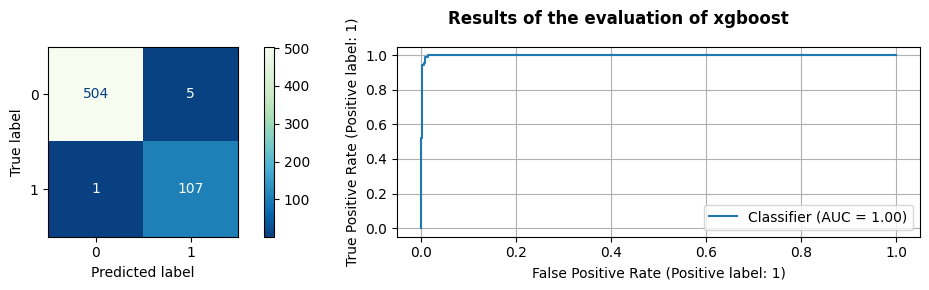

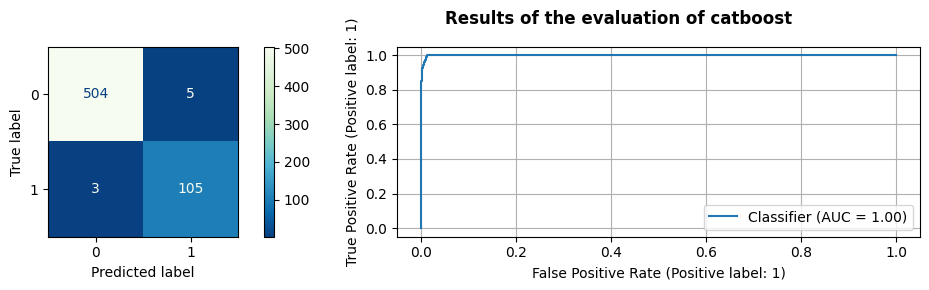

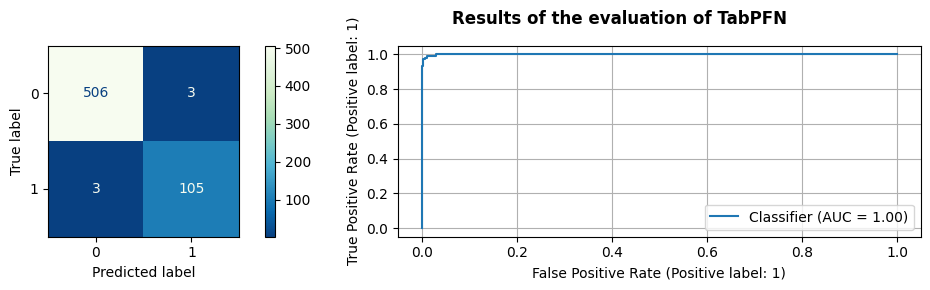

In [92]:
for method in y_preds:
    y_true = y  # Replace y with your ground truth y values
    y_pred = y_preds[method]
    show_confusion_roc(y_true, y_pred,title=f'Results of the evaluation of {method}')

## Oversampling and time feature

In [10]:
times = greeks.Epsilon.copy()
times[greeks.Epsilon != 'Unknown'] = greeks.Epsilon[greeks.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks.Epsilon == 'Unknown'] = np.nan

In [11]:
#concatenating data with Epsilon
train_time = pd.concat((train, times), axis=1)
test_predictors = test[predictor_columns]
test_time = np.concatenate((test_predictors, np.zeros((len(test_predictors), 1)) + train_time.Epsilon.max() + 1), axis=1)

In [16]:
ros = RandomOverSampler(random_state=seed)
train_ros, y_ros = ros.fit_resample(train_time, greeks.Alpha)
print('Original dataset shape')
print(greeks.Alpha.value_counts())
print('Resample dataset shape')
print( y_ros.value_counts())

y_ = train_ros.Class
x_ros = train_ros.drop(['Class', 'Id'],axis=1)

Original dataset shape
A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64
Resample dataset shape
B    509
A    509
D    509
G    509
Name: Alpha, dtype: int64


In [74]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
x_ros['Epsilon'] = imputer.fit_transform(x_ros['Epsilon'].values.reshape(-1, 1))

y_preds_ros = {} # Initialize arrays to store predictions for each method

for method in ['lightgbm', 'xgboost', 'catboost', 'TabPFN']:
    model_ros, _ = boosting_CV_methods(method, x_ros, y_)
    y_pred_ros = model_ros.predict_proba(x_ros)[:, 1]  # Use the entire dataset for predictions
    y_preds_ros[method] = y_pred_ros

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------------------------------------------------
lightgbm training fold 1
best_model_saved
>val_loss=0.24567
--------------------------------------------------
lightgbm training fold 2
>val_loss=0.49542
--------------------------------------------------
lightgbm training fold 3
>val_loss=0.37031
--------------------------------------------------
lightgbm training fold 4
best_model_saved
>val_loss=0.13220
--------------------------------------------------
lightgbm training fold 5
>val_loss=0.26773
LOSS: 0.30227 



--------------------------------------------------
xgboost training fold 1
best_model_saved
>val_loss=0.61417
--------------------------------------------------
xgboost training fold 2
best_model_saved
>val_loss=0.24771
--------------------------------------------------
xgboost training fold 3
>val_loss=0.74063
--------------------------------------------------
xgboost training fold 4
best_model_saved
>val_loss=0.13220
--------------------------------------------------
xgbo

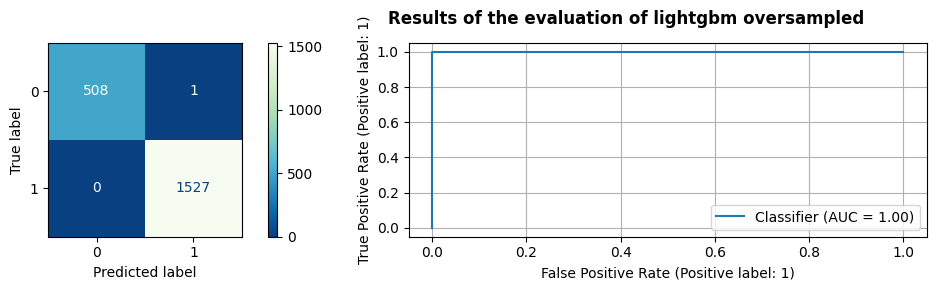

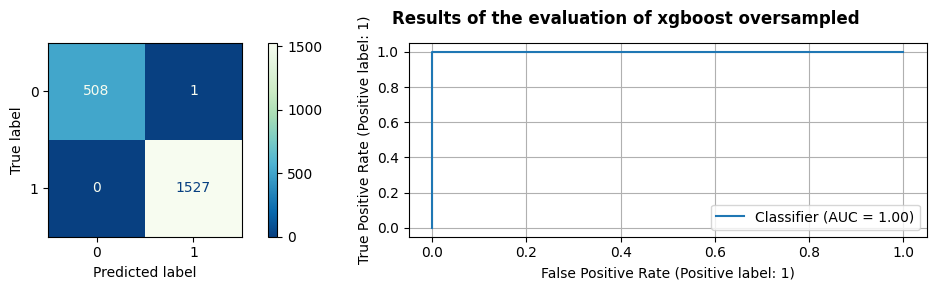

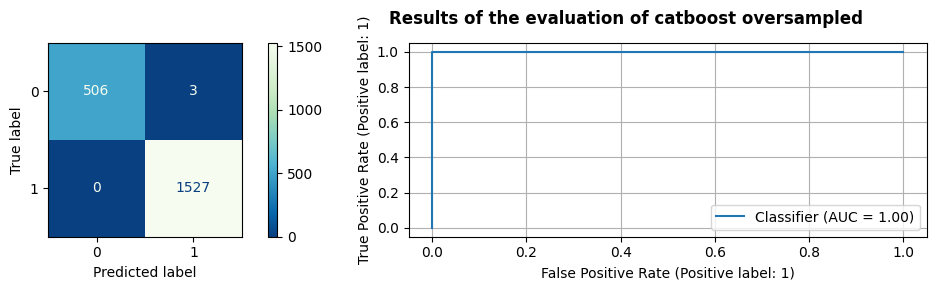

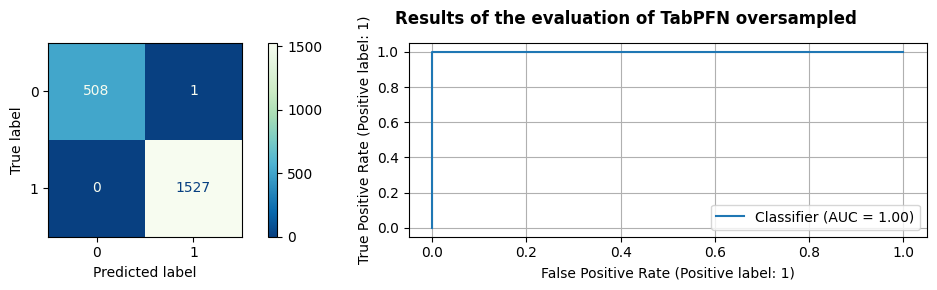

In [93]:
for method in y_preds_ros:
    y_true_ros = y_  # Replace y with your ground truth y values
    y_pred_ros = y_preds_ros[method]
    show_confusion_roc(y_true_ros, y_pred_ros, title=f'Results of the evaluation of {method} oversampled')

# Ensemble final model, greeks.Alpha

We'll create an ensemble model that combines lgb.LGBMClassifier and TabPFNClassifier models. The ensemble will make predictions based on both classifiers' results, considering class imbalance in the data. By using ensemble techniques, we aim to enhance the overall classification performance compared to using each classifier separately.

In [68]:
class Ensemble():
    def __init__(self):
        super().__init__()
        self.classifiers =[lgb.LGBMClassifier(),TabPFNClassifier(N_ensemble_configurations=64)]

    def fit(self, X, y):
        y = y.values
        unique_classes, y = np.unique(y, return_inverse=True)
        self.classes_ = unique_classes
        for classifier in self.classifiers:
            if classifier == self.classifiers[1]:
                classifier.fit(X, y, overwrite_warning=True)
            else:
                classifier.fit(X, y)

    def predict_proba(self, X):
        probabilities = np.stack([classifier.predict_proba(X) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i == 0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)

In the code above, we set two target variables for model training.

* **y_train:** which represents the output variable corresponding to x_train. Contains the known results corresponding to the variable Alpha (which identifies the type of age-related condition, if present). Labels that the model will attempt to predict during training.

* **y_val:** that corresponds to the Class variable that is the objective of the study.

This method trains on the relationships that exist between the variables and the alpha column, not just on the Class column.

In [69]:
def training(model, x,y,y_meta):
    outer_results = list()
    best_loss = np.inf
    split = 0
    splits = 5
    for train_idx,val_idx in tqdm(KF(n_splits = 5, shuffle=True, random_state=42).split(x), total = splits):
        print('-'*50)
        split+=1
        print(f'training fold {split}')

        x_train, x_val = x.iloc[train_idx],x.iloc[val_idx]
        y_train, y_val = y_meta.iloc[train_idx], y.iloc[val_idx]

        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_val)
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1) #Class 1
        p0 = probabilities[:,:1] #Class 0
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        y_p = y_p.astype(int)
        loss = balanced_log_loss(y_val,y_p)

        if loss<best_loss:
            best_model = model
            best_loss = loss
            print('best_model_saved')
        outer_results.append(loss)
        print('>val_loss=%.5f' % loss)
    print('LOSS: %.5f' % (np.mean(outer_results)))
    return best_model

In [70]:
yt = Ensemble()
m = training(yt,x_ros,y_,y_ros)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------------------------------------
training fold 1
best_model_saved
>val_loss=0.12283
--------------------------------------------------
training fold 2
best_model_saved
>val_loss=0.00000
--------------------------------------------------
training fold 3
>val_loss=0.00000
--------------------------------------------------
training fold 4
best_model_saved
>val_loss=0.00000
--------------------------------------------------
training fold 5
>val_loss=0.13386
LOSS: 0.05134


# Inference on test data

In [71]:
y_pred = m.predict_proba(test_time)

# Convert probabilities to binary predictions using a threshold (greeks.Alpha)
probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1) #Class 1
p0 = probabilities[:,:1]
p0[p0 > 0.74] = 1
p0[p0 < 0.26] = 0

The reason for performing two conversions with different threshold values is that the first conversion (0.86 and 0.14) it is used for evaluation or analysis related to the Classes, while the second conversion (0.74 and 0.26) it is used for a different evaluation, Alpha feature. This approach allows for greater flexibility in adjusting the binary predictions based on different requirements or criteria.

In [94]:
submission = pd.DataFrame(test["Id"], columns=["Id"])
submission["class_0"] = p0
submission["class_1"] = 1 - p0
submission.to_csv('submission.csv', index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


# Conclusions

* The final ensemble model, comprised of the classifiers lgb.LGBMClassifier() and TabPFNClassifier(N_ensemble_configurations=64), exhibits promising performance in predicting the registration outcomes. The model's average loss, measured at 0.05, indicates that the predictions are made with high accuracy.

* Furthermore, the ROC curves analysis highlights the model's effectiveness in predicting both class 0 and class 1 of the dataset, especially when the data is oversampled to address class imbalance. The ensemble approach leverages the strengths of individual classifiers and effectively handles the class imbalance issue, leading to improved prediction outcomes and overall model performance.